<a href="https://colab.research.google.com/github/saumilhj/dsai_projects/blob/main/Dinosaur_Name_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**DINOSAUR NAME GENERATOR**

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Import data

In [2]:
with open('dinos.txt') as file:
  data = file.read().lower()

### Data Preprocessing

Two dictionaries are made, one to map character to a number and another to map number to a character

In [3]:
# Sorted list that takes all unique characters from the text
chars = sorted(list(set(data)), reverse=True)
# Dictionaries
chars_to_id = {c:i for i, c in enumerate(chars)}
id_to_chars = {i:c for i, c in enumerate(chars)}

Convert all words in the input data to integer sequences

In [4]:
def convert_names_to_sequences(input_data):
  name_sequences = []
  word_seq = []
  for char in list(input_data):
    if char=='\n':
      word_seq.append(chars_to_id[char])
      name_sequences.append(word_seq)
      word_seq = []
    else:
      word_seq.append(chars_to_id[char])
  return name_sequences

In [5]:
name_sequences = convert_names_to_sequences(data)

In [63]:
print(f"Number of dinosaur names: {len(name_sequences)}")

Number of dinosaur names: 1535


Convert the input sequences to training data with appropriate padding. I have used N-gram approach to prepare the data.

In [6]:
def prepare_training_data(sequences):
  training_sequences = []
  for name_seq in sequences:
    for i in range(len(name_seq)-1):
      seq = name_seq[:i+2]
      training_sequences.append(seq)
  padded_sequences = tf.keras.utils.pad_sequences(training_sequences, padding='pre')
  return padded_sequences

In [7]:
training_data = prepare_training_data(name_sequences)

In [8]:
# Length of the longest sequences
max_seq_len = max([len(seq) for seq in training_data])

Split training data into inputs and labels

In [9]:
training_input = training_data[:, :-1]
# One-hot encoding labels
training_labels = tf.keras.utils.to_categorical(training_data[:, -1], num_classes=len(chars))

### Model

In [12]:
def create_model():
  tf.random.set_seed(42)
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(len(chars), 64, input_length=max_seq_len-1),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(len(chars), activation='softmax')
  ])
  return model

In [ ]:
model = create_model()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(training_input, training_labels, verbose=1, epochs=50)

Accuracy achieved after training for 50 epochs is about 80%

Plot loss and accuracy

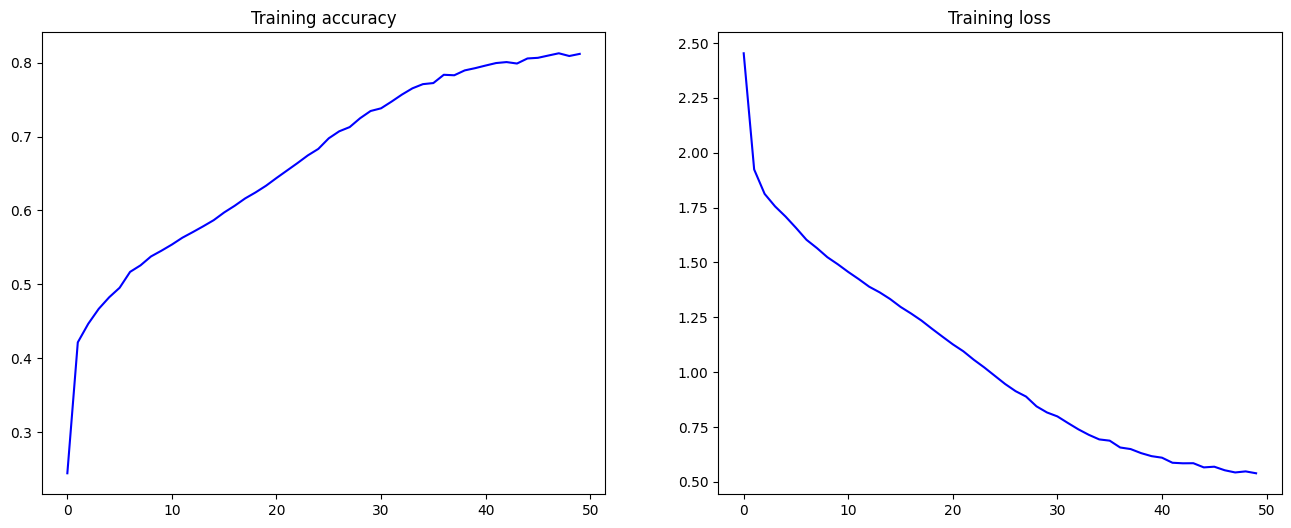

In [14]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')

plt.show()

Generate random names

In [61]:
gen_names = 10
char_l = []
new_word = True
total_words = 0
print(f"Generating {gen_names} names ...")
while total_words < gen_names:
  if new_word:
    char = id_to_chars[np.random.choice(list(id_to_chars.keys())[:26])]
    newline_count = 0
    new_word = False
  else:
    for c in char:
      char_l.append(chars_to_id[c])
    padded_char_l = tf.keras.utils.pad_sequences([char_l], maxlen=max_seq_len-1, padding='pre')
    predicted = model.predict(padded_char_l, verbose=0)[0]
    predicted = np.argmax(predicted)
    output = id_to_chars[predicted]
    char = char + output
    if output == '\n':
      new_word = True
      total_words +=1
      char = char[:-1]
      print(char.capitalize())

Generating 10 names ...
Ishchus
Mysaurus
X
Nus
Ks
Oleus
Qs
Bus
Ps
Ylolus


The names generated above show that the network has learned that dino names end with an S or X but it can lead to some bad outputs. To correct this, I have modified the function to ignore such outputs

In [62]:
gen_names = 10
char_l = []
new_word = True
total_words = 0
print(f"Generating {gen_names} names ...")
while total_words < gen_names:
  if new_word:
    char = id_to_chars[np.random.choice(list(id_to_chars.keys())[:26])]
    newline_count = 0
    new_word = False
  else:
    for c in char:
      char_l.append(chars_to_id[c])
    padded_char_l = tf.keras.utils.pad_sequences([char_l], maxlen=max_seq_len-1, padding='pre')
    predicted = model.predict(padded_char_l, verbose=0)[0]
    predicted = np.argmax(predicted)
    output = id_to_chars[predicted]
    char = char + output
    if output == '\n':
      newline_count += 1
      if len(char) > 6:
        new_word = True
        total_words +=1
        char = char[:-1]
        print(char.capitalize())
      elif newline_count == 4:
        new_word = True
      else:
        char = char[:-1]

Generating 10 names ...
Oredon
Esaurus
Urochenosaurus
Trosaurus
Zoaeuraptor
Josaurus
Miodon
Rosaurus
Nllong
Qsiosus
